In [216]:
import pandas as pd
import numpy as np
import sklearn
from pyod.models.pca import PCA as pyod_PCA
import matplotlib.pyplot as plt

In [217]:
train_full = pd.read_csv('train_dataset.csv')
test_full = pd.read_csv('test_dataset.csv')

In [218]:
train_full.shape, test_full.shape

((250408, 172), (27824, 170))

In [219]:
set(train_full.columns) - set(test_full.columns)

{'AMT_CREDIT', 'TARGET'}

In [220]:
features = [
    'app_Income_credit_ratio',
    'app_Annuity_income_ratio',
    'AMT_CREDIT_mean',
#     'AMT_ANNUITY_mean',
    'approved_credit_ratio_mean',
    'AMT_ANNUITY_credit_ratio_mean',
#     'Interest_ratio_mean',
#     'LTV_ratio_mean',
    'approved_ratio',
    'Active',
    'Approved',
    'Highest_balance_over_last_12months',
#     'payment_cover_ratio_mean',
    'payment_diff_mean',
    'Day_past_due_max',
    'APARTMENTS_AVG',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'EXT_SOURCE_1',
    'REGION_RATING_CLIENT',
    'DAYS_EMPLOYED',
#     'DAYS_BIRTH',
    'EXT_SOURCE_3',
    'NAME_INCOME_TYPE',
    'CNT_CHILDREN',
    'EXT_SOURCE_2',
    'FLAG_OWN_CAR',
    'NAME_EDUCATION_TYPE',
    'DATE',
#     'AMT_INCOME_TOTAL'
]

targets = [
    'TARGET',
    'AMT_CREDIT',
]

In [221]:
train = train_full[features+targets].copy()
test = test_full[features].copy()

In [222]:
train.dtypes[train.dtypes==object]

NAME_INCOME_TYPE       object
FLAG_OWN_CAR           object
NAME_EDUCATION_TYPE    object
DATE                   object
dtype: object

In [223]:
train['DATE'] = pd.to_datetime(train['DATE'])
test['DATE'] = pd.to_datetime(test['DATE'])


In [224]:
train['Active_approved'] = train['Active'] + train['Approved']
test['Active_approved']  = test['Active']  + test['Approved']

train = train.drop(columns=['Active', 'Approved'])
test  = test.drop (columns=['Active', 'Approved'])



In [225]:
print(train['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts())
print(train['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts())
print(train['REGION_RATING_CLIENT'].value_counts())
print(train['CNT_CHILDREN'].value_counts())


0.0    221411
1.0     23312
2.0      4433
3.0       986
4.0       208
5.0        47
6.0         9
8.0         1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64
0.0      174737
1.0       28306
2.0       11890
3.0        1469
4.0         393
5.0          52
6.0          25
8.0           6
7.0           6
261.0         1
19.0          1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64
2    185324
3     39531
1     25553
Name: REGION_RATING_CLIENT, dtype: int64
0     176793
1      48645
2      21524
3       3003
4        338
5         68
6         19
7          6
14         3
10         2
19         2
8          2
11         1
9          1
12         1
Name: CNT_CHILDREN, dtype: int64


In [226]:
interval_attributes = test.columns[test.dtypes != object].to_list()
interval_attributes.remove('DATE')
cat_attributes = test.columns[test.dtypes == object].to_list()


interval_like_cat = ['DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'REGION_RATING_CLIENT', 'CNT_CHILDREN']
for i in interval_like_cat:
    interval_attributes.remove(i)
    cat_attributes.append(i)



In [227]:
train['DATE'].min(), train['DATE'].max() 

(Timestamp('2000-01-01 00:00:00'), Timestamp('2002-12-31 00:00:00'))

In [228]:
def make_test_flg(data_, part):
    month_list = list(data_.sort_values('DATE')['DATE'].drop_duplicates())
    month_num = round(part * len(month_list))
    data_['test_flg'] = np.where(data_['DATE'] > month_list[month_num], 1, 0)
    print(f'Месяц деления на train test: {month_list[month_num]}')
    return data_

In [229]:
part = 0.7 
train = make_test_flg(data_ = train, part = part)

Месяц деления на train test: 2002-02-06 00:00:00


In [230]:
def information_train_test(data_):
    temp = data_.groupby('test_flg').agg({'TARGET' : ['count', 'mean', 'sum']})
    temp.columns = ['Кол-во наблюдений', 'Уровень дефолта', 'Кол-во дефолтных наблюдений']
    temp['Доля популяции'] = temp['Кол-во наблюдений'] / data_.shape[0]
    return temp

information_train_test(train)

,Кол-во наблюдений,Уровень дефолта,Кол-во дефолтных наблюдений,Доля популяции
test_flg,,,,
0,175416,0.083670,14677,0.700521
1,74992,0.083729,6279,0.299479


In [307]:
# train.describe().T

In [232]:
# def draw_feature_distribution(data_, interval, category):
#     for col in interval + category:
#         print(f'Отображение распределений для атрибута: {col}')
        
#         temp_train = data_[data_['test_flg']==0][['TARGET', col]]
#         temp_test = data_[data_['test_flg']==1][['TARGET', col]]

#         bins = 50

#         # Визуализация
#         fig = plt.figure(figsize=(24,8))
#         ax_1 = fig.add_subplot(1, 2, 1)
#         ax_2 = fig.add_subplot(1, 2, 2)

#         ax_1.set_title('Распределение атрибута для разного целевого события на train выборке')
#         ax_1.hist([temp_train[temp_train['TARGET']==0][col], 
#                 temp_train[temp_train['TARGET']==1][col]], 
#                 color=['b','r'],  alpha=0.7, bins=bins, histtype='step', label=['TARGET = 0', 'TARGET = 1'])
#         ax_1.set_xlabel(col)
#         ax_1.set_ylabel('Количество наблюдений')
#         ax_1.legend()

#         ax_2.set_title('Распределение атрибута для разного целевого события на test выборке')
#         ax_2.hist([temp_test[temp_test['TARGET']==0][col], 
#                 temp_test[temp_test['TARGET']==1][col]], 
#                 color=['b','r'],  alpha=0.7, bins=bins, histtype='step', label=['TARGET = 0', 'TARGET = 1'])
#         ax_2.set_xlabel(col)
#         ax_2.set_ylabel('Количество наблюдений')
#         ax_2.legend()

#         plt.show()
#         print()


# draw_feature_distribution(data_ = train,
#                           interval = train.columns[train.dtypes!=object].to_list(), 
#                           category = train.columns[train.dtypes==object].to_list())

In [233]:
train.columns[train.dtypes==object]

Index(['NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE'], dtype='object')

In [234]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 128431
Commercial associate     57204
Pensioner                46838
State servant            17908
Unemployed                  13
Student                     12
Maternity leave              2
Name: NAME_INCOME_TYPE, dtype: int64

In [235]:
train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    180122
Higher education                  58740
Incomplete higher                  8112
Lower secondary                    3300
Academic degree                     134
Name: NAME_EDUCATION_TYPE, dtype: int64

In [236]:
train['FLAG_OWN_CAR'].value_counts()

N    165405
Y     85003
Name: FLAG_OWN_CAR, dtype: int64

In [237]:
income_type_to_num = {
    'Working' : 0,
    'Commercial associate' : 2,
    'Pensioner' : 4,
    'State servant' : 1,
    'Unemployed': 6, 
    'Student' : 3,
    'Maternity leave' : 5,
}

ed_type_to_num = {
    'Secondary / secondary special':1,
    'Higher education':3,
    'Incomplete higher':2,
    'Lower secondary'  :0,
    'Academic degree' : 4
}

train['NAME_INCOME_TYPE'] = train['NAME_INCOME_TYPE'].replace(income_type_to_num).astype(int)
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].replace(ed_type_to_num).astype(int)
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace({'Y':1, 'N':0}).astype(int)

test['NAME_INCOME_TYPE'] = test['NAME_INCOME_TYPE'].replace(income_type_to_num).astype(int)
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].replace(ed_type_to_num).astype(int)
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace({'Y':1, 'N':0}).astype(int)

<AxesSubplot:>

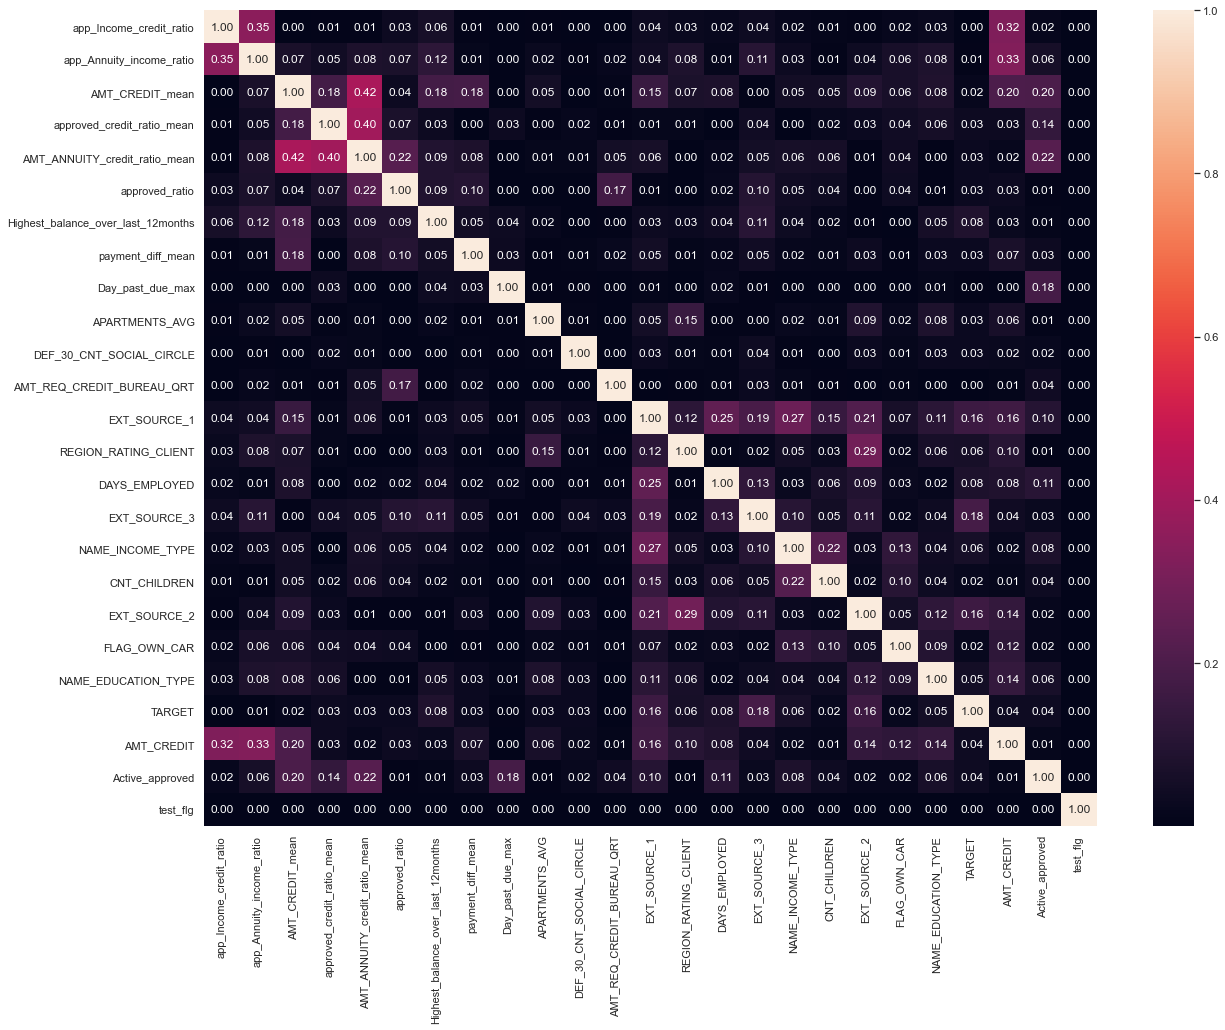

In [238]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 15)})
sns.heatmap(abs(train.corr()), annot=True, fmt='.2f')

In [239]:

def find_outliers(data_tr, data_ts):
    clf_tr = pyod_PCA(contamination=0.01, random_state=42)
    train_labels = clf_tr.fit(data_tr).labels_
    test_labels = clf_tr.predict(data_ts)

    return train_labels, test_labels

In [240]:
outliers_labels_train, outliers_labels_test = find_outliers(data_tr = train.drop(columns=['DATE', 'TARGET', 'AMT_CREDIT', 'test_flg']).fillna(train.mean()),
                                                            data_ts = test.drop(columns=['DATE']).fillna(test.mean())
                                                            )

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


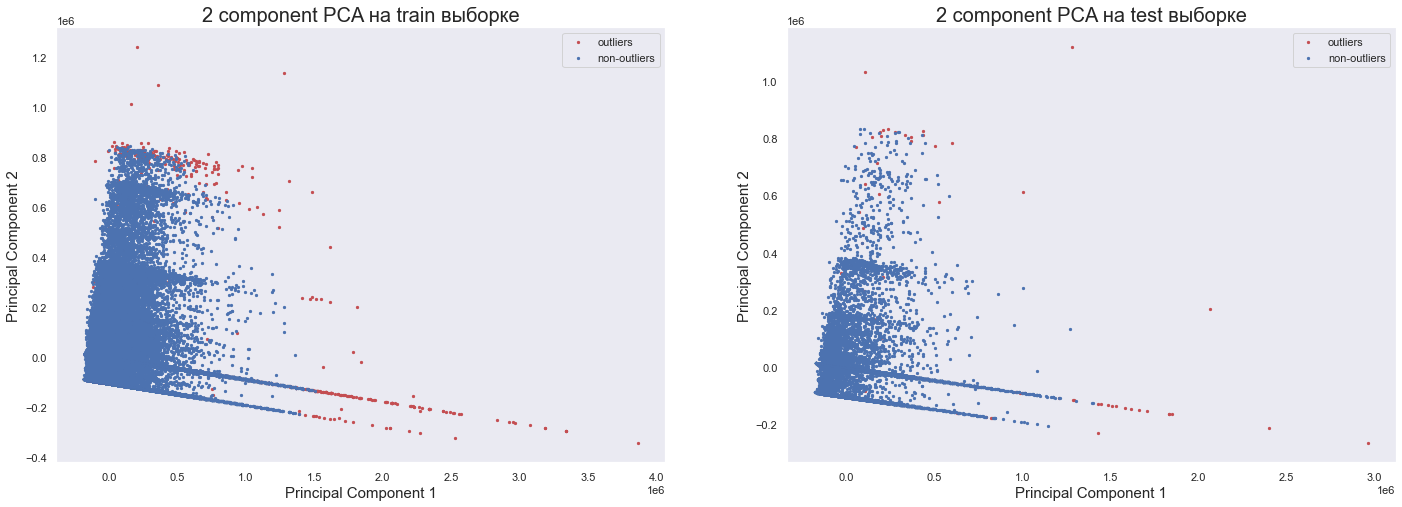

In [241]:
# Применения PCA для визуализации
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents_train = pca.fit_transform(train.drop(columns=['DATE', 'TARGET', 'AMT_CREDIT', 'test_flg']).fillna(train.mean()))
principalComponents_test = pca.transform(test.drop(columns=['DATE']).fillna(test.mean()))
principalDf_train = pd.DataFrame(data = principalComponents_train, 
                                 columns = ['principal component 1', 'principal component 2']
                                 )
principalDf_test = pd.DataFrame(data = principalComponents_test, 
                                columns = ['principal component 1', 'principal component 2']
                                )

# Визуализация
fig = plt.figure(figsize = (24,8))
ax_1 = fig.add_subplot(1,2,1) 
ax_2 = fig.add_subplot(1,2,2) 

ax_1.set_xlabel('Principal Component 1', fontsize = 15)
ax_1.set_ylabel('Principal Component 2', fontsize = 15)
ax_1.set_title('2 component PCA на train выборке', fontsize = 20)
ax_1.scatter(principalDf_train.loc[(outliers_labels_train == 1), 'principal component 1'],
             principalDf_train.loc[(outliers_labels_train == 1), 'principal component 2'],
             c = 'r',
             s = 5)
ax_1.scatter(principalDf_train.loc[(outliers_labels_train == 0), 'principal component 1'],
             principalDf_train.loc[(outliers_labels_train == 0), 'principal component 2'],
             c = 'b',
             s = 5)
ax_1.legend(['outliers', 'non-outliers'])
ax_1.grid()

ax_2.set_xlabel('Principal Component 1', fontsize = 15)
ax_2.set_ylabel('Principal Component 2', fontsize = 15)
ax_2.set_title('2 component PCA на test выборке', fontsize = 20)
ax_2.scatter(principalDf_test.loc[(outliers_labels_test == 1), 'principal component 1'],
             principalDf_test.loc[(outliers_labels_test == 1), 'principal component 2'],
             c = 'r',
             s = 5)
ax_2.scatter(principalDf_test.loc[(outliers_labels_test == 0), 'principal component 1'],
             principalDf_test.loc[(outliers_labels_test == 0), 'principal component 2'],
             c = 'b',
             s = 5)
ax_2.legend(['outliers', 'non-outliers'])
ax_2.grid()

In [242]:
def calc_binning(data_, interval_attributes, num_bins):
    res = {}
    for atr in interval_attributes:
#         print(atr, data_[atr].notna().sum())
        cut, bins = pd.qcut(data_[atr][data_[atr].notna()], num_bins, retbins=True, duplicates='drop')
#         bins = np.round(bins, 5)
        bins = bins[1:-1]
        res[atr] = bins
    return res
    

In [243]:
binnings = calc_binning(train, interval_attributes, 10)

In [244]:
binnings

{'app_Income_credit_ratio': array([0.12972572, 0.16666667, 0.2       , 0.24027309, 0.28571429,
        0.33980583, 0.41173349, 0.51596037, 0.71633238]),
 'app_Annuity_income_ratio': array([0.08684327, 0.11154545, 0.13212098, 0.1518    , 0.1722    ,
        0.19436   , 0.22103333, 0.25508571, 0.3092    ]),
 'AMT_CREDIT_mean': array([ 40437.  ,  58662.  ,  76477.5 ,  95940.  , 119475.  , 148889.25,
        191164.5 , 254700.  , 368898.  ]),
 'approved_credit_ratio_mean': array([0.79801514, 0.88596253, 0.92042235, 0.94751865, 0.9693555 ,
        0.99850534, 1.00956706, 1.04734891, 1.11112629]),
 'AMT_ANNUITY_credit_ratio_mean': array([0.06015299, 0.07357014, 0.08398605, 0.09348399, 0.10245523,
        0.11110008, 0.12015987, 0.13639918, 0.16390013]),
 'approved_ratio': array([0.55555556, 0.66666667, 0.8       ]),
 'Highest_balance_over_last_12months': array([ 34482.69 , 126021.915, 194935.185, 339845.625]),
 'payment_diff_mean': array([-563.64745424,    0.        ,  274.44016419,  720.593

In [245]:
def make_grps(data_, interval_attributes, category_attributes, dict_binning):
    for col in interval_attributes:
        bins = [-np.inf] + dict_binning[col].tolist() + [+np.inf]
        data_['GRP_'+str(col)] = pd.cut(data_[col], bins).astype(str)        
        data_['GRP_'+str(col)] = data_['GRP_'+str(col)].str.replace('inf]', '+inf)', regex=True)
        data_['GRP_'+str(col)] = data_['GRP_'+str(col)].str.replace('nan', 'MISSING', regex=True)

    for col in category_attributes:
        data_['GRP_'+str(col)] = data_[col].astype(str).str.replace('nan', 'MISSING', regex=True)
        
    return data_

In [246]:
train = make_grps(train, interval_attributes, cat_attributes, binnings)
test = make_grps(test, interval_attributes, cat_attributes, binnings)

In [247]:
def calc_woe(data_, attributes_, target_name):
    eps = 0.00001
    res_dict = {}
    for col in attributes_:
        df = data_[['GRP_'+str(col), target_name]]
        val_counts = df.groupby(target_name)['GRP_'+col].value_counts()
        
        bad = val_counts[1]/df[target_name].value_counts()[1]
        good = val_counts[0]/df[target_name].value_counts()[0]
        bad_good = pd.concat([good.rename('good'), bad.rename('bad')], axis=1).fillna(eps)
        
        res_df = np.log(bad_good['bad']/bad_good['good'])
        
        res_df = res_df.fillna(eps)
        res_df = res_df.to_frame('WOE_'+col).reset_index()
        res_dict[str(col)] = res_df

    return res_dict

In [248]:
woe_dict = calc_woe(train[train['test_flg'] == 0], interval_attributes+cat_attributes, 'TARGET')

In [249]:
def merge_woe(data_, attributes_, dict_woe, how):
    for col in attributes_:
        woes = dict_woe[col]
        data_ = data_.merge(woes, on='GRP_'+str(col), how=how)
    return data_

In [250]:
train = merge_woe(train, interval_attributes+cat_attributes, woe_dict, how='inner')
test  = merge_woe(test , interval_attributes+cat_attributes, woe_dict, how='left')

In [252]:
# (train.loc[:, test.columns.str.startswith('WOE')] < -1000).sum()

In [253]:
test['WOE_DEF_30_CNT_SOCIAL_CIRCLE'] = test['WOE_DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)

In [254]:
test.shape

(27824, 67)

In [255]:
train.shape

(250405, 70)

In [256]:
from sklearn.metrics import roc_auc_score
def one_factor_analyses_function(data_, attributes_, target_name, test_flg_name):
    gini_train =[]
    gini_test = []
    psi = []
    train_ = data_[data_[test_flg_name] == 0]
    test_ = data_[data_[test_flg_name] == 1]
    
    for col in attributes_:                    
        x_dev = train['GRP_'+col].value_counts()/len(train)
        x_val = test['GRP_'+col].value_counts()/len(test)
        psi.append( ((x_val-x_dev) * np.log(x_val/x_dev)).sum() )
        
        gini_train.append(abs(2*roc_auc_score(train_[target_name], train_['WOE_'+col]) - 1))
        gini_test.append(abs(2*roc_auc_score(test_[target_name], test_['WOE_'+col]) - 1))
        
    gini_train = np.array(gini_train)
    gini_test = np.array(gini_test)
    
    res_df = pd.DataFrame({'Attribute': attributes_,  
                           'GINI test': gini_test, 
                           'GINI train': gini_train, 
                           'GINI delta': (gini_test-gini_train)/gini_train,
                           'PSI' : psi})
    return res_df


In [257]:
one_factor_analyses = one_factor_analyses_function(train, interval_attributes+cat_attributes, 'TARGET', 'test_flg')

In [258]:
one_factor_analyses.sort_values('GINI train', ascending=False)

,Attribute,GINI test,GINI train,GINI delta,PSI
12,EXT_SOURCE_3,0.323672,0.311010,0.040712,1.565152e-04
13,EXT_SOURCE_2,0.306424,0.302361,0.013436,8.823070e-05
11,DAYS_EMPLOYED,0.191133,0.189168,0.010389,6.272331e-04
10,EXT_SOURCE_1,0.173166,0.171431,0.010121,6.482483e-04
15,NAME_INCOME_TYPE,0.132555,0.124512,0.064593,1.903713e-04
3,approved_credit_ratio_mean,0.113500,0.123597,-0.081700,3.479856e-04
7,payment_diff_mean,0.110565,0.113002,-0.021566,2.816345e-05
6,Highest_balance_over_last_12months,0.101032,0.105080,-0.038529,2.806124e-04
8,Day_past_due_max,0.113780,0.103881,0.095290,3.943351e-04
14,Active_approved,0.091992,0.102141,-0.099364,2.620866e-04


In [259]:
good_features_long = list(one_factor_analyses[(one_factor_analyses['GINI train'] > 0.05)
                                               & (abs(one_factor_analyses['GINI delta']) < 0.50)
                                               & (one_factor_analyses['PSI'] < 0.20)
                                             ].sort_values('GINI train', ascending=False)['Attribute'])


In [260]:
good_features_long

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'NAME_INCOME_TYPE',
 'approved_credit_ratio_mean',
 'payment_diff_mean',
 'Highest_balance_over_last_12months',
 'Day_past_due_max',
 'Active_approved',
 'REGION_RATING_CLIENT',
 'APARTMENTS_AVG',
 'NAME_EDUCATION_TYPE',
 'AMT_ANNUITY_credit_ratio_mean',
 'app_Income_credit_ratio',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'approved_ratio',
 'AMT_CREDIT_mean']

In [261]:
corr_matrix = train[train['test_flg']==0][['WOE_'+col for col in good_features_long]].corr(method='spearman')
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`


,WOE_EXT_SOURCE_3,WOE_EXT_SOURCE_2,WOE_DAYS_EMPLOYED,WOE_EXT_SOURCE_1,WOE_NAME_INCOME_TYPE,WOE_approved_credit_ratio_mean,WOE_payment_diff_mean,WOE_Highest_balance_over_last_12months,WOE_Day_past_due_max,WOE_Active_approved,WOE_REGION_RATING_CLIENT,WOE_APARTMENTS_AVG,WOE_NAME_EDUCATION_TYPE,WOE_AMT_ANNUITY_credit_ratio_mean,WOE_app_Income_credit_ratio,WOE_AMT_REQ_CREDIT_BUREAU_QRT,WOE_approved_ratio,WOE_AMT_CREDIT_mean
WOE_EXT_SOURCE_3,1.00,0.10,0.16,0.09,0.08,0.06,0.08,0.08,0.06,0.05,0.01,0.01,-0.03,0.05,0.06,0.18,0.07,0.01
WOE_EXT_SOURCE_2,0.10,1.00,0.07,0.13,0.05,0.06,0.04,0.04,0.03,0.02,0.32,0.14,0.12,0.01,0.01,0.04,0.01,0.08
WOE_DAYS_EMPLOYED,0.16,0.07,1.00,0.16,0.43,-0.00,-0.00,0.05,-0.03,0.12,-0.02,0.01,-0.09,-0.05,0.05,0.04,-0.01,0.04
WOE_EXT_SOURCE_1,0.09,0.13,0.16,1.00,0.10,0.03,0.02,0.04,-0.01,0.05,0.06,0.06,0.09,-0.03,0.04,0.03,-0.00,0.06
WOE_NAME_INCOME_TYPE,0.08,0.05,0.43,0.10,1.00,-0.00,0.02,0.01,0.01,0.06,0.06,0.03,0.00,-0.04,0.03,0.00,-0.02,0.06
WOE_approved_credit_ratio_mean,0.06,0.06,-0.00,0.03,-0.00,1.00,0.13,-0.04,0.19,-0.10,0.05,0.03,0.09,0.46,0.02,0.02,0.23,-0.08
WOE_payment_diff_mean,0.08,0.04,-0.00,0.02,0.02,0.13,1.00,0.04,0.63,-0.13,0.01,0.03,0.04,0.09,0.02,0.01,0.05,0.10
WOE_Highest_balance_over_last_12months,0.08,0.04,0.05,0.04,0.01,-0.04,0.04,1.00,0.00,0.06,0.01,0.02,-0.01,-0.00,0.03,0.02,0.05,0.01
WOE_Day_past_due_max,0.06,0.03,-0.03,-0.01,0.01,0.19,0.63,0.00,1.00,-0.30,-0.00,0.03,0.06,0.18,0.01,-0.01,0.12,0.05
WOE_Active_approved,0.05,0.02,0.12,0.05,0.06,-0.10,-0.13,0.06,-0.30,1.00,0.00,0.01,-0.05,-0.11,0.02,0.04,0.04,0.26


In [262]:
good_features_long.remove('payment_diff_mean')

In [263]:
# Печатаем Биннинг
def print_binning(data, interval_attributes, category_attributes, target, test_flg_name, figsize=(16,8), h_pt=16):
    for i, col in enumerate(interval_attributes+category_attributes):
#         clear_output(wait=True)
        print(f'Column {i+1}/{len(interval_attributes+category_attributes)}')
#         print(col)
        
        
        temp = data.groupby([test_flg_name, col]).agg({target : ['count', 'sum']}).reset_index().sort_values(col)
        temp.columns = [test_flg_name, col, 'cnt', 'def_cnt']
        temp['def_rate'] = temp['def_cnt'] / temp['cnt']
        temp = temp.merge(data.groupby(test_flg_name).agg({target : 'count'}).reset_index(), on=[test_flg_name], how='left')
        temp['pop_rate'] = temp['cnt'] / temp[target]
        temp = temp.drop(columns=[target])
        
        
        
        if col in interval_attributes:
            temp['sort_col'] = temp[col].apply(lambda x: np.inf if 'MISSING' in x else float(x[1:-1].split(',')[0]) if x[1:-1].split(',')[0] != '-inf' else -np.inf)
        elif col in category_attributes:
            temp['sort_col'] = temp[col].apply(lambda x: np.inf if 'MISSING' in x else float(x))
        temp = temp.sort_values([test_flg_name, 'sort_col'])
        temp = temp.drop(columns=['sort_col'])
        temp_tr = temp[temp[test_flg_name]==0]
        temp_ts = temp[temp[test_flg_name]==1]
    
        fig, ax1 = plt.subplots(figsize=figsize)
        color = 'tab:blue'
        h_pt = h_pt
        col_name = col.replace('GRP_','')
        ax1.set_title('Распределение доли популяции и уровня дефолта по группам фактора\n'+col_name, fontsize=h_pt)
        ax1.set_xlabel('Группы фактора ' + col_name, fontsize=h_pt)
        ax1.set_ylabel('Доля популяции', fontsize=h_pt)

        plt.bar(temp_tr[col], temp_tr['pop_rate'], align='edge', width=-0.4, edgecolor='black', color=color, label='train')
        plt.bar(temp_ts[col], temp_ts['pop_rate'], align='edge', width=0.4, edgecolor='black', color='lightblue', label='test')
        plt.legend(loc='upper left')

        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Уровень дефолта', fontsize=h_pt)

        plt.plot(temp_tr[col], temp_tr['def_rate'], '+-r', linewidth=5, markersize=20, label='train') 
        plt.plot(temp_ts[col], temp_ts['def_rate'], '+-g', linewidth=5, markersize=20, label='test') 
        plt.legend(loc='upper right')

        ax2.tick_params('y')
        fig.tight_layout()

        plt.show()


        # Печатаем расчетную таблицу
        with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
            print(temp)

Column 1/17


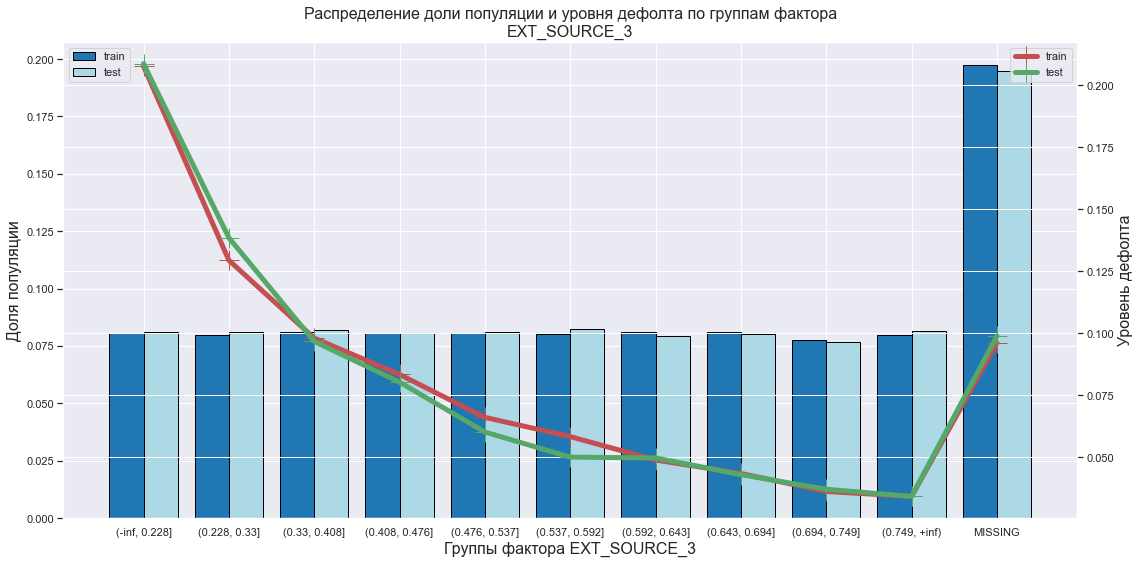

    test_flg GRP_EXT_SOURCE_3    cnt  def_cnt  def_rate  pop_rate
0          0    (-inf, 0.228]  14120     2933     0.208     0.080
2          0    (0.228, 0.33]  13997     1811     0.129     0.080
4          0    (0.33, 0.408]  14206     1392     0.098     0.081
6          0   (0.408, 0.476]  14150     1179     0.083     0.081
8          0   (0.476, 0.537]  14133      933     0.066     0.081
10         0   (0.537, 0.592]  14062      819     0.058     0.080
12         0   (0.592, 0.643]  14259      696     0.049     0.081
14         0   (0.643, 0.694]  14244      618     0.043     0.081
17         0   (0.694, 0.749]  13595      491     0.036     0.078
19         0    (0.749, +inf)  14007      478     0.034     0.080
20         0          MISSING  34643     3327     0.096     0.197
1          1    (-inf, 0.228]   6066     1266     0.209     0.081
3          1    (0.228, 0.33]   6066      840     0.138     0.081
5          1    (0.33, 0.408]   6145      594     0.097     0.082
7         

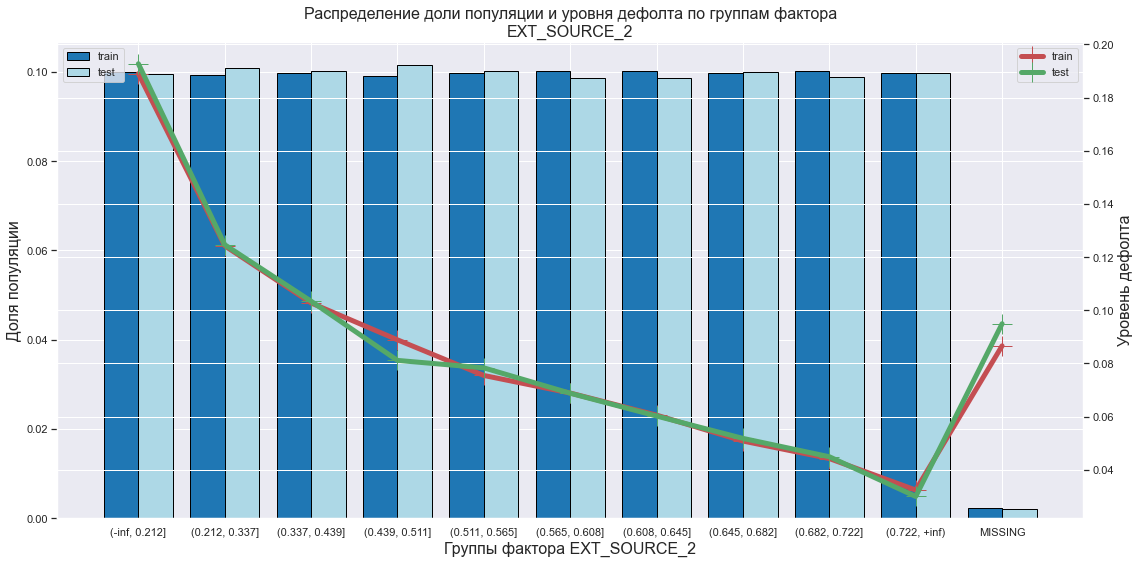

    test_flg GRP_EXT_SOURCE_2    cnt  def_cnt  def_rate  pop_rate
0          0    (-inf, 0.212]  17526     3312     0.189     0.100
2          0   (0.212, 0.337]  17419     2164     0.124     0.099
4          0   (0.337, 0.439]  17483     1796     0.103     0.100
6          0   (0.439, 0.511]  17374     1544     0.089     0.099
8          0   (0.511, 0.565]  17478     1319     0.075     0.100
10         0   (0.565, 0.608]  17586     1211     0.069     0.100
12         0   (0.608, 0.645]  17590     1065     0.061     0.100
14         0   (0.645, 0.682]  17498      889     0.051     0.100
17         0   (0.682, 0.722]  17570      777     0.044     0.100
19         0    (0.722, +inf)  17511      567     0.032     0.100
20         0          MISSING    381       33     0.087     0.002
1          1    (-inf, 0.212]   7462     1438     0.193     0.100
3          1   (0.212, 0.337]   7566      943     0.125     0.101
5          1   (0.337, 0.439]   7505      776     0.103     0.100
7         

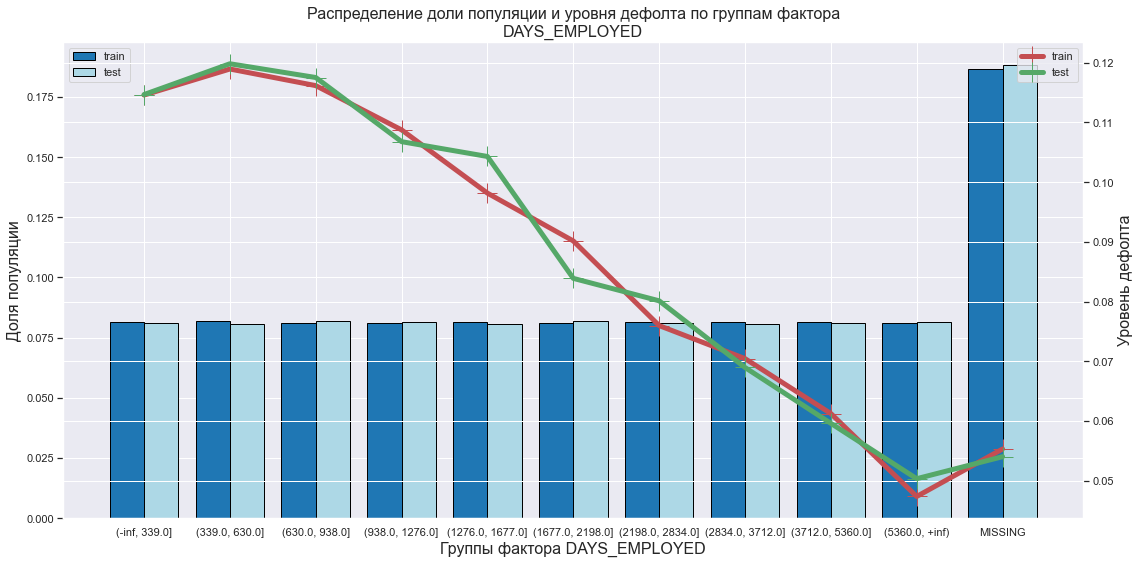

    test_flg GRP_DAYS_EMPLOYED    cnt  def_cnt  def_rate  pop_rate
0          0     (-inf, 339.0]  14288     1637     0.115     0.081
10         0    (339.0, 630.0]  14361     1708     0.119     0.082
17         0    (630.0, 938.0]  14214     1651     0.116     0.081
19         0   (938.0, 1276.0]  14208     1545     0.109     0.081
2          0  (1276.0, 1677.0]  14325     1406     0.098     0.082
4          0  (1677.0, 2198.0]  14189     1279     0.090     0.081
6          0  (2198.0, 2834.0]  14269     1084     0.076     0.081
8          0  (2834.0, 3712.0]  14310     1008     0.070     0.082
12         0  (3712.0, 5360.0]  14272      874     0.061     0.081
14         0    (5360.0, +inf)  14254      675     0.047     0.081
20         0           MISSING  32726     1810     0.055     0.187
1          1     (-inf, 339.0]   6079      697     0.115     0.081
11         1    (339.0, 630.0]   6051      725     0.120     0.081
16         1    (630.0, 938.0]   6127      720     0.118     0

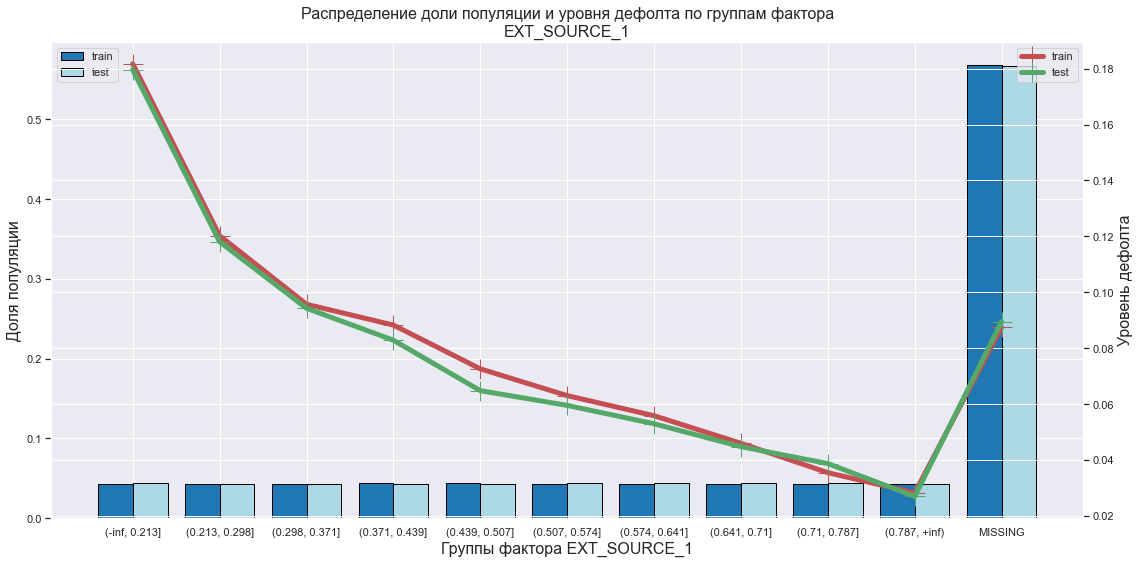

    test_flg GRP_EXT_SOURCE_1    cnt  def_cnt  def_rate  pop_rate
0          0    (-inf, 0.213]   7555     1373     0.182     0.043
2          0   (0.213, 0.298]   7594      913     0.120     0.043
4          0   (0.298, 0.371]   7609      728     0.096     0.043
6          0   (0.371, 0.439]   7615      672     0.088     0.043
8          0   (0.439, 0.507]   7618      553     0.073     0.043
10         0   (0.507, 0.574]   7554      476     0.063     0.043
12         0   (0.574, 0.641]   7489      418     0.056     0.043
14         0    (0.641, 0.71]   7529      346     0.046     0.043
17         0    (0.71, 0.787]   7531      267     0.035     0.043
19         0    (0.787, +inf)   7584      214     0.028     0.043
20         0          MISSING  99738     8717     0.087     0.569
1          1    (-inf, 0.213]   3258      585     0.180     0.043
3          1   (0.213, 0.298]   3219      380     0.118     0.043
5          1   (0.298, 0.371]   3204      302     0.094     0.043
7         

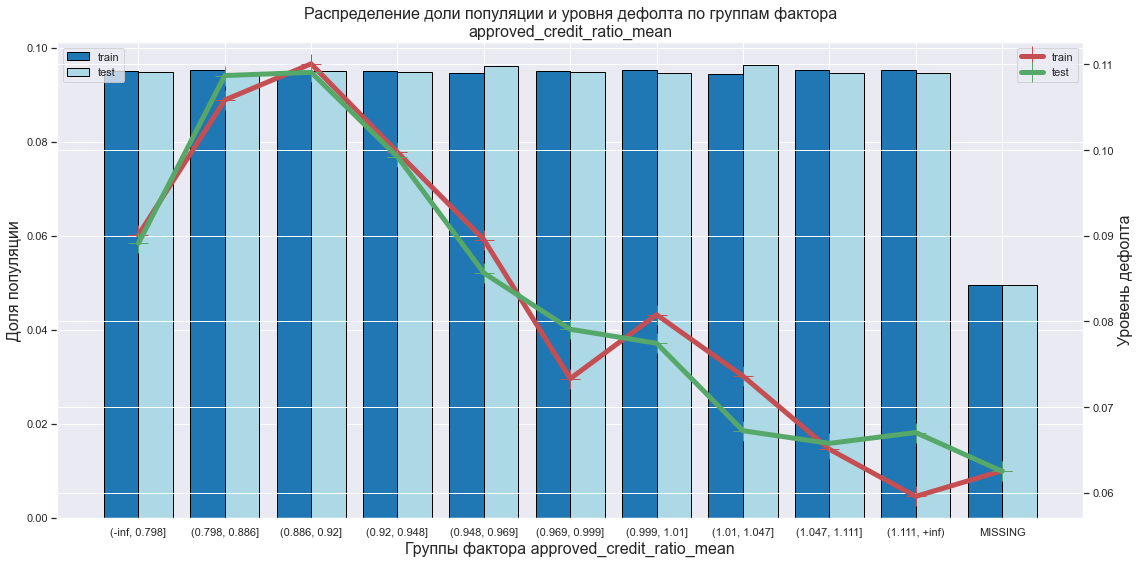

    test_flg GRP_approved_credit_ratio_mean    cnt  def_cnt  def_rate  \
0          0                  (-inf, 0.798]  16685     1503     0.090   
2          0                 (0.798, 0.886]  16724     1770     0.106   
4          0                  (0.886, 0.92]  16673     1835     0.110   
6          0                  (0.92, 0.948]  16683     1664     0.100   
8          0                 (0.948, 0.969]  16584     1485     0.090   
10         0                 (0.969, 0.999]  16692     1224     0.073   
12         0                  (0.999, 1.01]  16698     1349     0.081   
14         0                  (1.01, 1.047]  16571     1220     0.074   
17         0                 (1.047, 1.111]  16699     1087     0.065   
19         0                  (1.111, +inf)  16698      995     0.060   
20         0                        MISSING   8709      545     0.063   
1          1                  (-inf, 0.798]   7114      634     0.089   
3          1                 (0.798, 0.886]   7075 

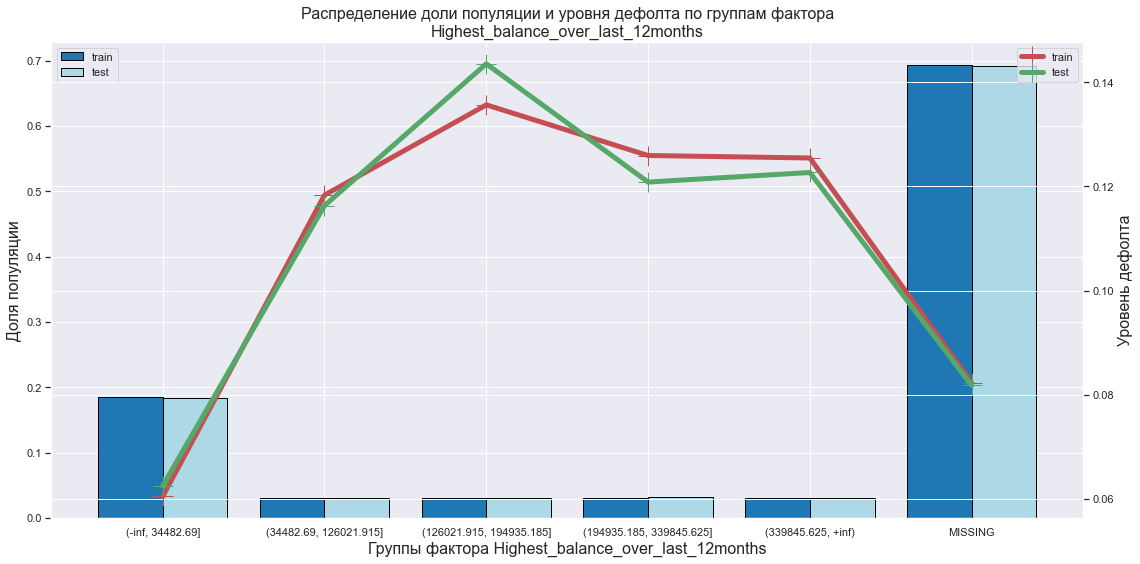

    test_flg GRP_Highest_balance_over_last_12months     cnt  def_cnt  \
0          0                       (-inf, 34482.69]   32349     1957   
8          0                 (34482.69, 126021.915]    5383      637   
2          0               (126021.915, 194935.185]    5381      730   
4          0               (194935.185, 339845.625]    5312      669   
6          0                     (339845.625, +inf)    5372      674   
10         0                                MISSING  121619    10010   
1          1                       (-inf, 34482.69]   13774      861   
9          1                 (34482.69, 126021.915]    2304      268   
3          1               (126021.915, 194935.185]    2306      331   
5          1               (194935.185, 339845.625]    2375      287   
7          1                     (339845.625, +inf)    2315      284   
11         1                                MISSING   51915     4246   

    def_rate  pop_rate  
0      0.060     0.184  
8      0.118 

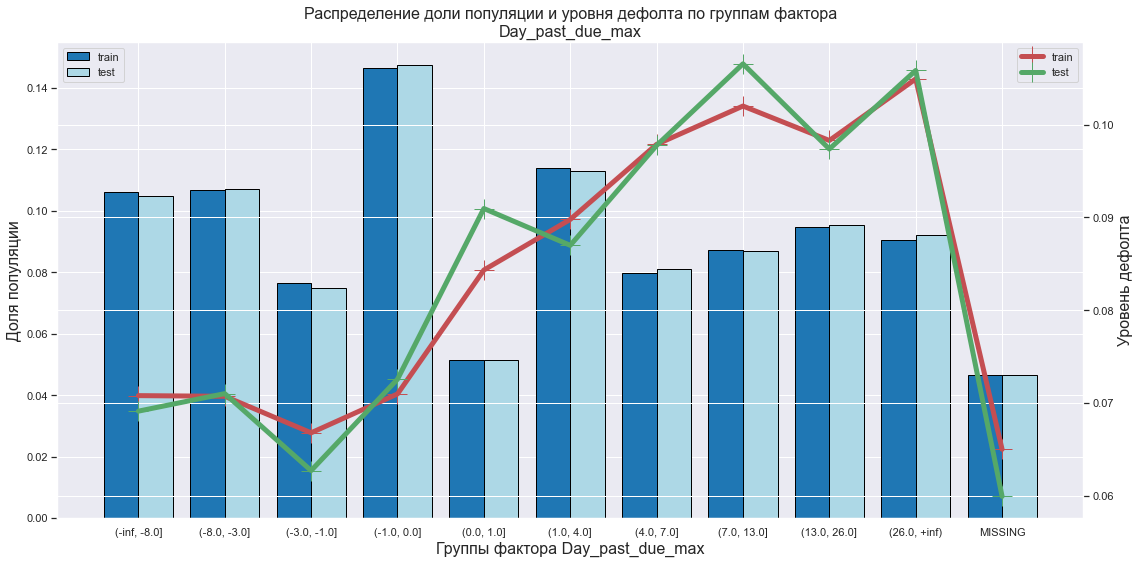

    test_flg GRP_Day_past_due_max    cnt  def_cnt  def_rate  pop_rate
6          0         (-inf, -8.0]  18606     1317     0.071     0.106
4          0         (-8.0, -3.0]  18738     1325     0.071     0.107
2          0         (-3.0, -1.0]  13418      896     0.067     0.076
0          0          (-1.0, 0.0]  25703     1824     0.071     0.147
8          0           (0.0, 1.0]   8989      758     0.084     0.051
10         0           (1.0, 4.0]  19960     1792     0.090     0.114
17         0           (4.0, 7.0]  13998     1370     0.098     0.080
19         0          (7.0, 13.0]  15313     1562     0.102     0.087
12         0         (13.0, 26.0]  16634     1635     0.098     0.095
14         0         (26.0, +inf)  15887     1667     0.105     0.091
20         0              MISSING   8170      531     0.065     0.047
7          1         (-inf, -8.0]   7857      543     0.069     0.105
5          1         (-8.0, -3.0]   8014      569     0.071     0.107
3          1        

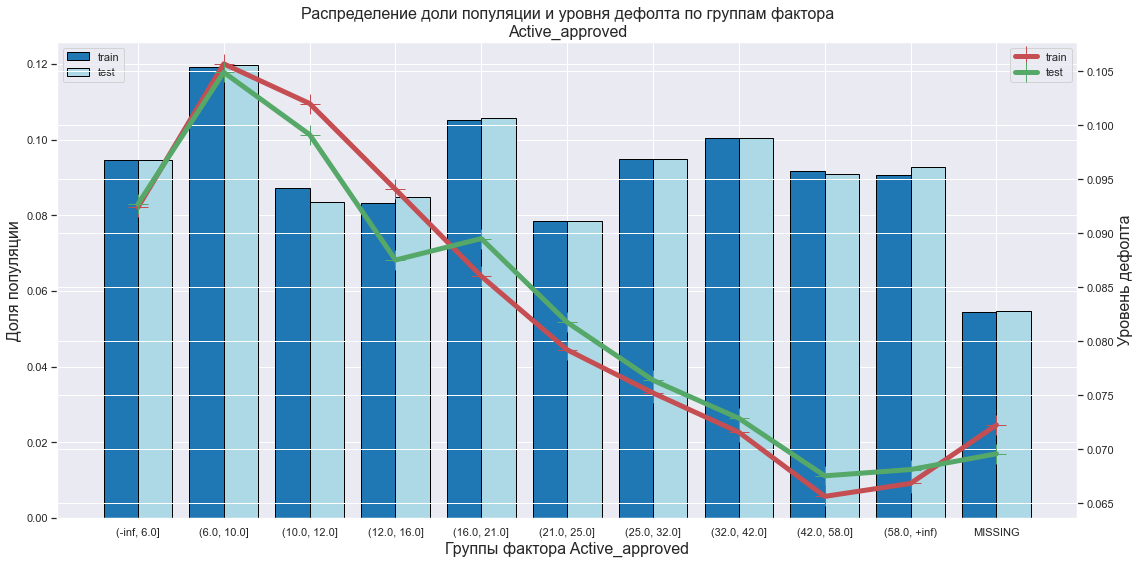

    test_flg GRP_Active_approved    cnt  def_cnt  def_rate  pop_rate
0          0         (-inf, 6.0]  16599     1534     0.092     0.095
19         0         (6.0, 10.0]  20897     2209     0.106     0.119
2          0        (10.0, 12.0]  15289     1560     0.102     0.087
4          0        (12.0, 16.0]  14594     1373     0.094     0.083
6          0        (16.0, 21.0]  18448     1587     0.086     0.105
8          0        (21.0, 25.0]  13785     1092     0.079     0.079
10         0        (25.0, 32.0]  16645     1252     0.075     0.095
12         0        (32.0, 42.0]  17631     1262     0.072     0.101
14         0        (42.0, 58.0]  16089     1056     0.066     0.092
17         0        (58.0, +inf)  15889     1062     0.067     0.091
20         0             MISSING   9550      690     0.072     0.054
1          1         (-inf, 6.0]   7086      657     0.093     0.094
18         1         (6.0, 10.0]   8978      942     0.105     0.120
3          1        (10.0, 12.0]  

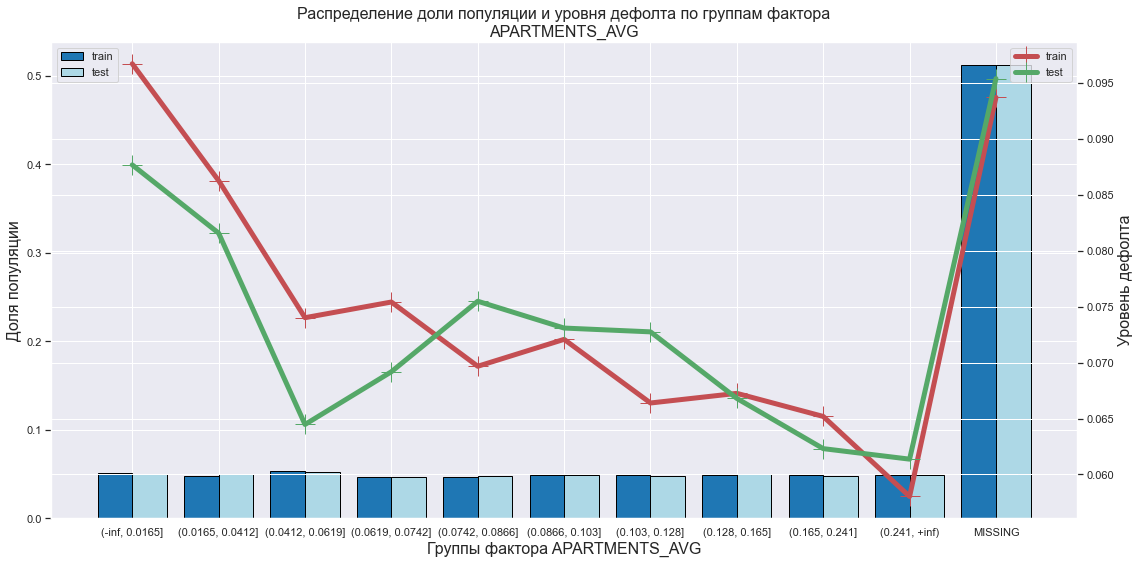

    test_flg GRP_APARTMENTS_AVG    cnt  def_cnt  def_rate  pop_rate
0          0     (-inf, 0.0165]   8885      859     0.097     0.051
2          0   (0.0165, 0.0412]   8360      721     0.086     0.048
4          0   (0.0412, 0.0619]   9324      690     0.074     0.053
6          0   (0.0619, 0.0742]   8090      610     0.075     0.046
8          0   (0.0742, 0.0866]   8139      567     0.070     0.046
10         0    (0.0866, 0.103]   8603      620     0.072     0.049
12         0     (0.103, 0.128]   8511      565     0.066     0.049
14         0     (0.128, 0.165]   8640      581     0.067     0.049
17         0     (0.165, 0.241]   8591      560     0.065     0.049
19         0      (0.241, +inf)   8460      491     0.058     0.048
20         0            MISSING  89813     8413     0.094     0.512
1          1     (-inf, 0.0165]   3708      325     0.088     0.049
3          1   (0.0165, 0.0412]   3703      302     0.082     0.049
5          1   (0.0412, 0.0619]   3909      252 

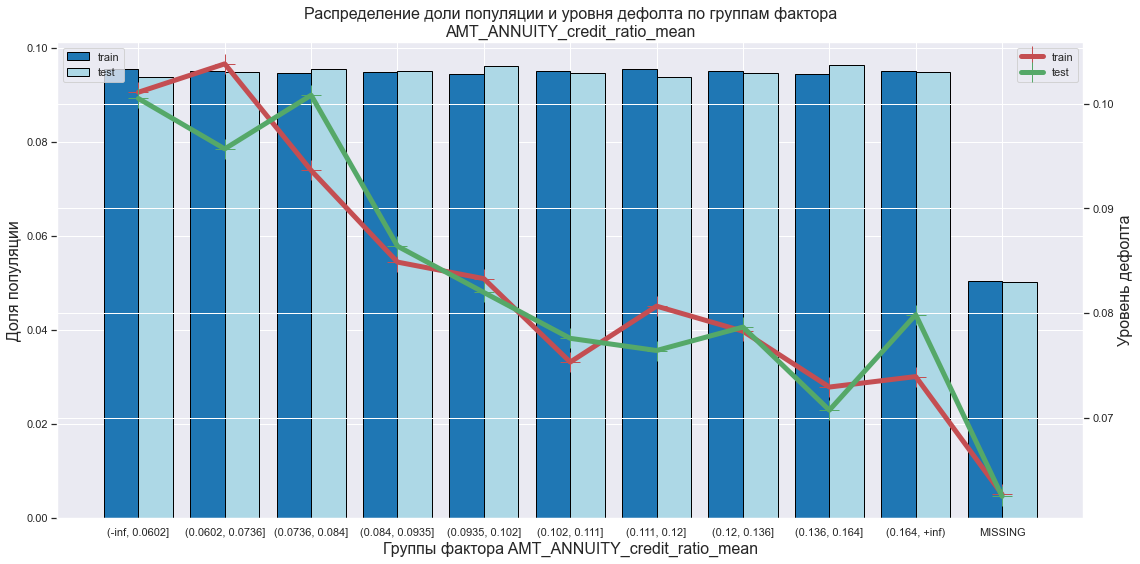

    test_flg GRP_AMT_ANNUITY_credit_ratio_mean    cnt  def_cnt  def_rate  \
0          0                    (-inf, 0.0602]  16747     1693     0.101   
2          0                  (0.0602, 0.0736]  16675     1731     0.104   
4          0                   (0.0736, 0.084]  16620     1556     0.094   
6          0                   (0.084, 0.0935]  16651     1413     0.085   
8          0                   (0.0935, 0.102]  16571     1380     0.083   
10         0                    (0.102, 0.111]  16679     1256     0.075   
12         0                     (0.111, 0.12]  16739     1350     0.081   
14         0                     (0.12, 0.136]  16689     1306     0.078   
17         0                    (0.136, 0.164]  16553     1207     0.073   
19         0                     (0.164, +inf)  16667     1232     0.074   
20         0                           MISSING   8825      553     0.063   
1          1                    (-inf, 0.0602]   7035      707     0.100   
3          1

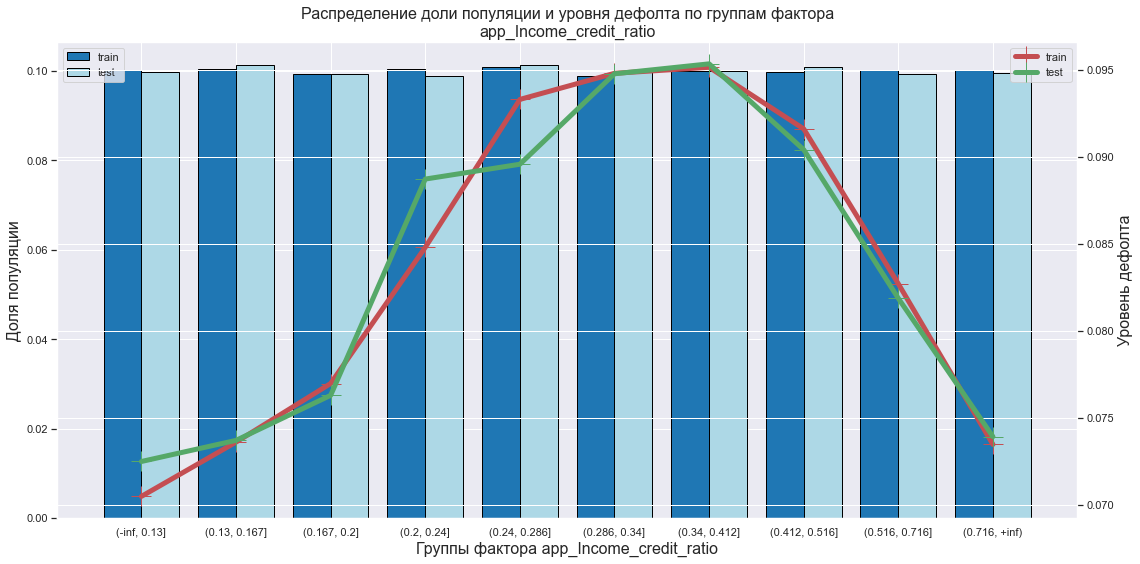

    test_flg GRP_app_Income_credit_ratio    cnt  def_cnt  def_rate  pop_rate
0          0                (-inf, 0.13]  17567     1238     0.070     0.100
2          0               (0.13, 0.167]  17624     1297     0.074     0.100
4          0                (0.167, 0.2]  17411     1340     0.077     0.099
6          0                 (0.2, 0.24]  17620     1494     0.085     0.100
8          0               (0.24, 0.286]  17686     1650     0.093     0.101
10         0               (0.286, 0.34]  17332     1643     0.095     0.099
12         0               (0.34, 0.412]  17532     1668     0.095     0.100
15         0              (0.412, 0.516]  17500     1603     0.092     0.100
17         0              (0.516, 0.716]  17583     1454     0.083     0.100
18         0               (0.716, +inf)  17561     1290     0.073     0.100
1          1                (-inf, 0.13]   7478      542     0.072     0.100
3          1               (0.13, 0.167]   7599      560     0.074     0.101

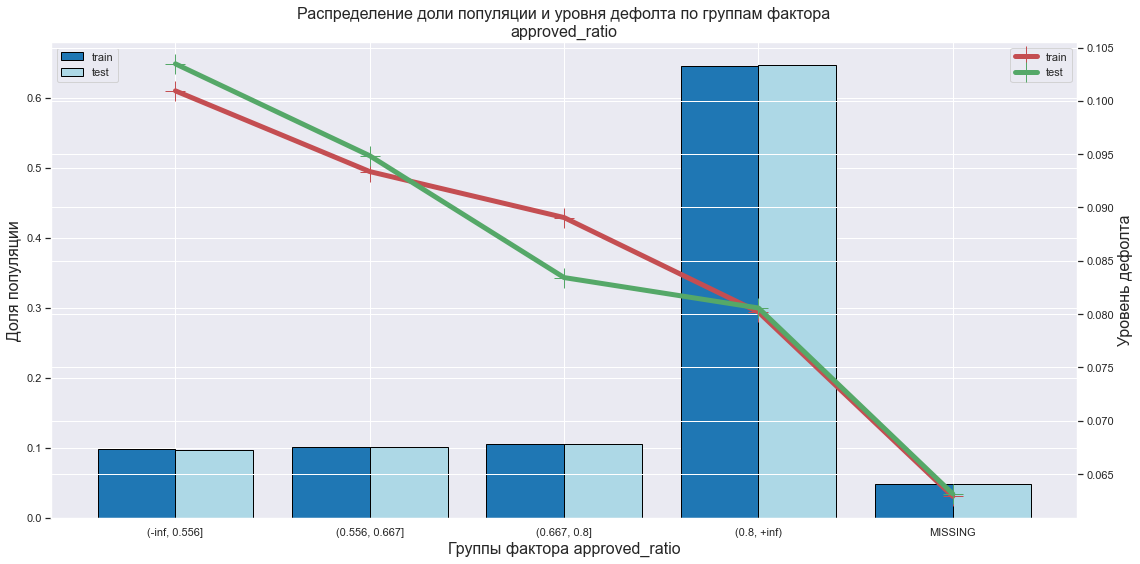

   test_flg GRP_approved_ratio     cnt  def_cnt  def_rate  pop_rate
0         0      (-inf, 0.556]   17357     1752     0.101     0.099
2         0     (0.556, 0.667]   17704     1653     0.093     0.101
4         0       (0.667, 0.8]   18494     1647     0.089     0.105
6         0        (0.8, +inf)  113293     9086     0.080     0.646
8         0            MISSING    8568      539     0.063     0.049
1         1      (-inf, 0.556]    7287      754     0.103     0.097
3         1     (0.556, 0.667]    7633      724     0.095     0.102
5         1       (0.667, 0.8]    7899      659     0.083     0.105
7         1        (0.8, +inf)   48512     3909     0.081     0.647
9         1            MISSING    3658      231     0.063     0.049
Column 13/17


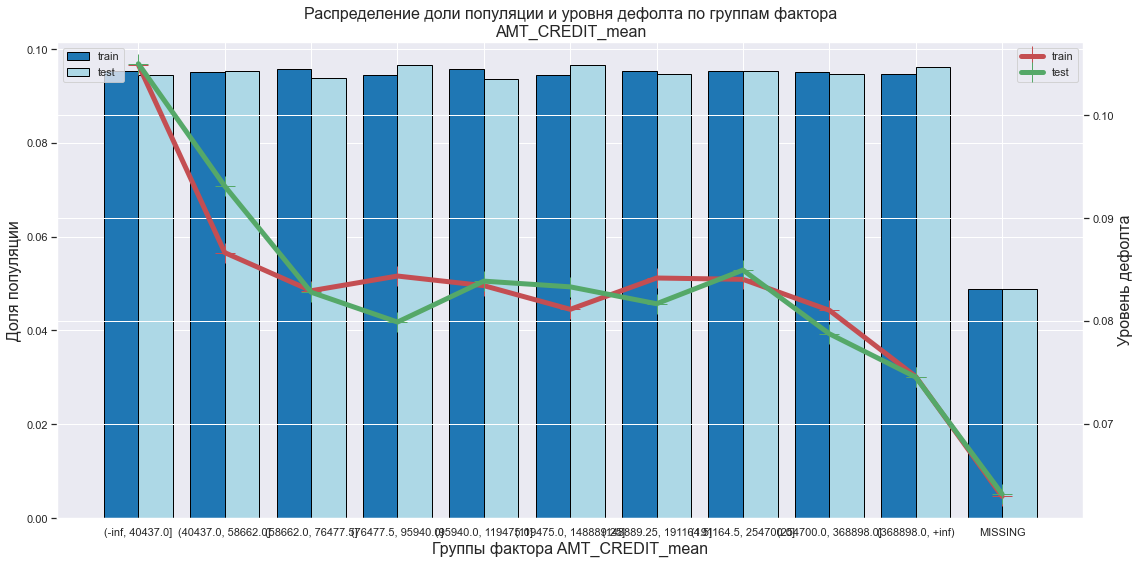

    test_flg    GRP_AMT_CREDIT_mean    cnt  def_cnt  def_rate  pop_rate
0          0        (-inf, 40437.0]  16735     1756     0.105     0.095
12         0     (40437.0, 58662.0]  16678     1445     0.087     0.095
14         0     (58662.0, 76477.5]  16785     1392     0.083     0.096
17         0     (76477.5, 95940.0]  16583     1399     0.084     0.095
19         0    (95940.0, 119475.0]  16781     1400     0.083     0.096
2          0  (119475.0, 148889.25]  16580     1345     0.081     0.095
4          0  (148889.25, 191164.5]  16716     1407     0.084     0.095
6          0   (191164.5, 254700.0]  16706     1404     0.084     0.095
8          0   (254700.0, 368898.0]  16685     1352     0.081     0.095
10         0       (368898.0, +inf)  16599     1238     0.075     0.095
20         0                MISSING   8568      539     0.063     0.049
1          1        (-inf, 40437.0]   7084      744     0.105     0.094
13         1     (40437.0, 58662.0]   7142      665     0.093   

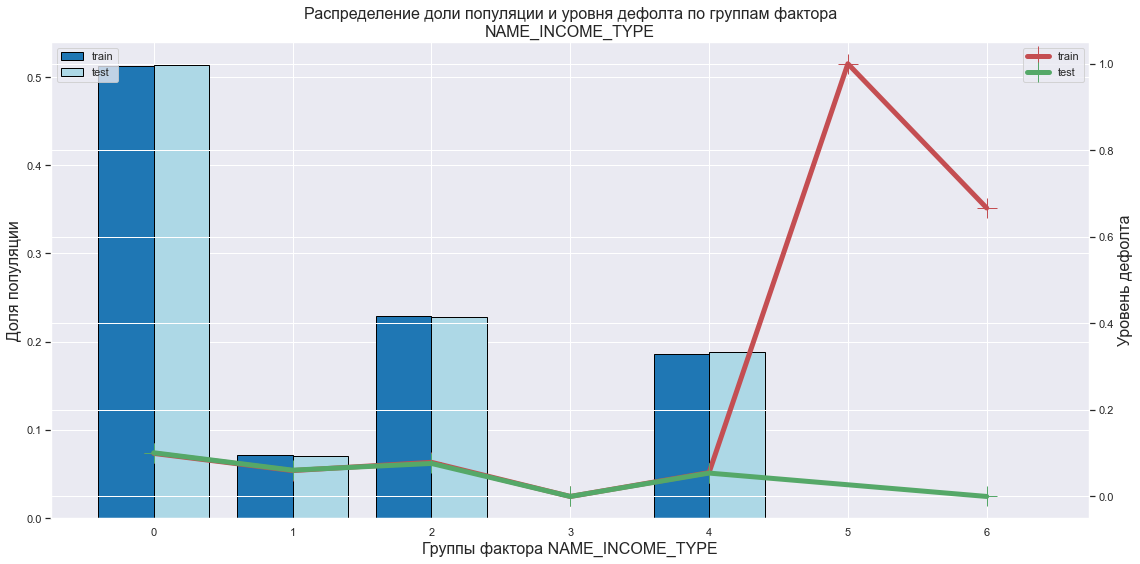

    test_flg GRP_NAME_INCOME_TYPE    cnt  def_cnt  def_rate   pop_rate
0          0                    0  89888     8940     0.099  5.124e-01
2          0                    1  12642      756     0.060  7.207e-02
4          0                    2  40148     3169     0.079  2.289e-01
6          0                    3     10        0     0.000  5.701e-05
8          0                    4  32717     1804     0.055  1.865e-01
10         0                    5      2        2     1.000  1.140e-05
11         0                    6      9        6     0.667  5.131e-05
1          1                    0  38541     3892     0.101  5.140e-01
3          1                    1   5266      320     0.061  7.022e-02
5          1                    2  17055     1302     0.076  2.274e-01
7          1                    3      2        0     0.000  2.667e-05
9          1                    4  14121      763     0.054  1.883e-01
12         1                    6      4        0     0.000  5.334e-05
Column

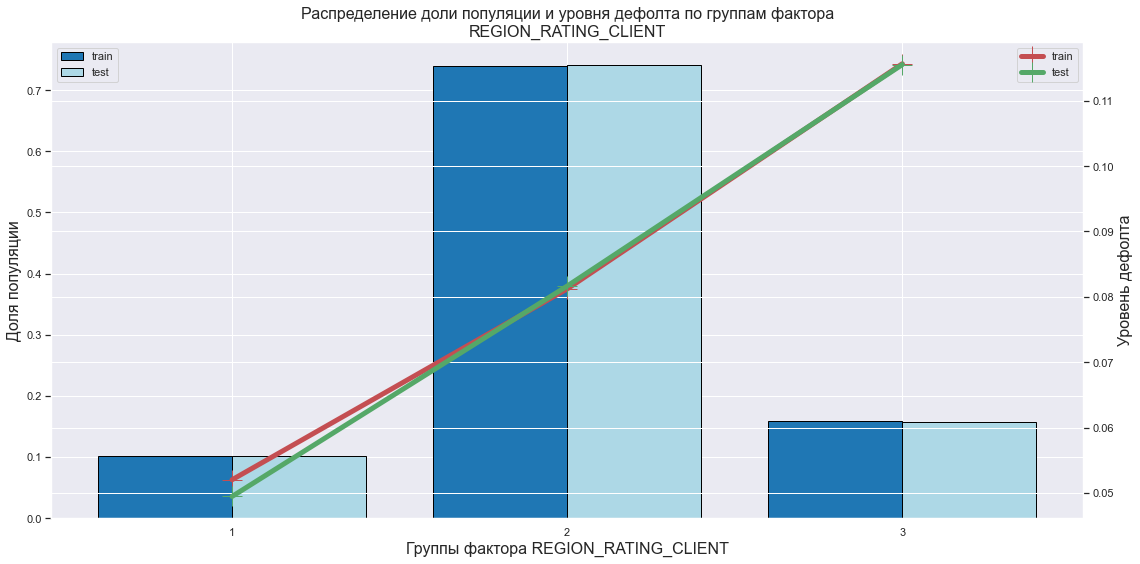

   test_flg GRP_REGION_RATING_CLIENT     cnt  def_cnt  def_rate  pop_rate
0         0                        1   17953      934     0.052     0.102
2         0                        2  129705    10533     0.081     0.739
4         0                        3   27758     3210     0.116     0.158
1         1                        1    7600      376     0.049     0.101
3         1                        2   55616     4541     0.082     0.742
5         1                        3   11773     1360     0.116     0.157
Column 16/17


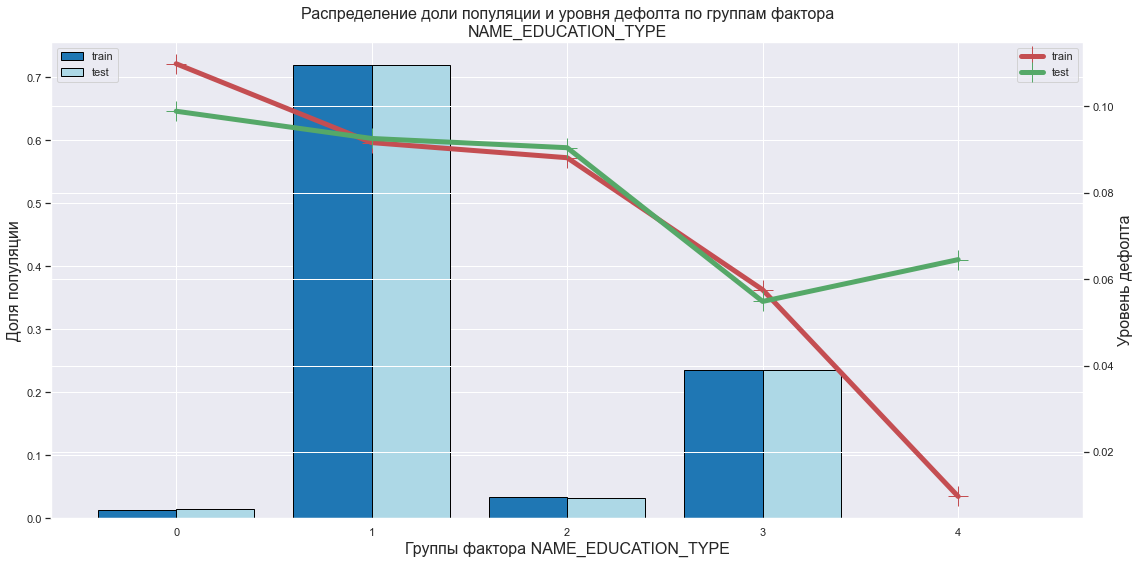

   test_flg GRP_NAME_EDUCATION_TYPE     cnt  def_cnt  def_rate   pop_rate
0         0                       0    2258      248     0.110  1.287e-02
2         0                       1  126146    11553     0.092  7.191e-01
4         0                       2    5767      508     0.088  3.288e-02
6         0                       3   41142     2367     0.058  2.345e-01
8         0                       4     103        1     0.010  5.872e-04
1         1                       0    1042      103     0.099  1.390e-02
3         1                       1   53974     4995     0.093  7.198e-01
5         1                       2    2345      212     0.090  3.127e-02
7         1                       3   17597      965     0.055  2.347e-01
9         1                       4      31        2     0.065  4.134e-04
Column 17/17


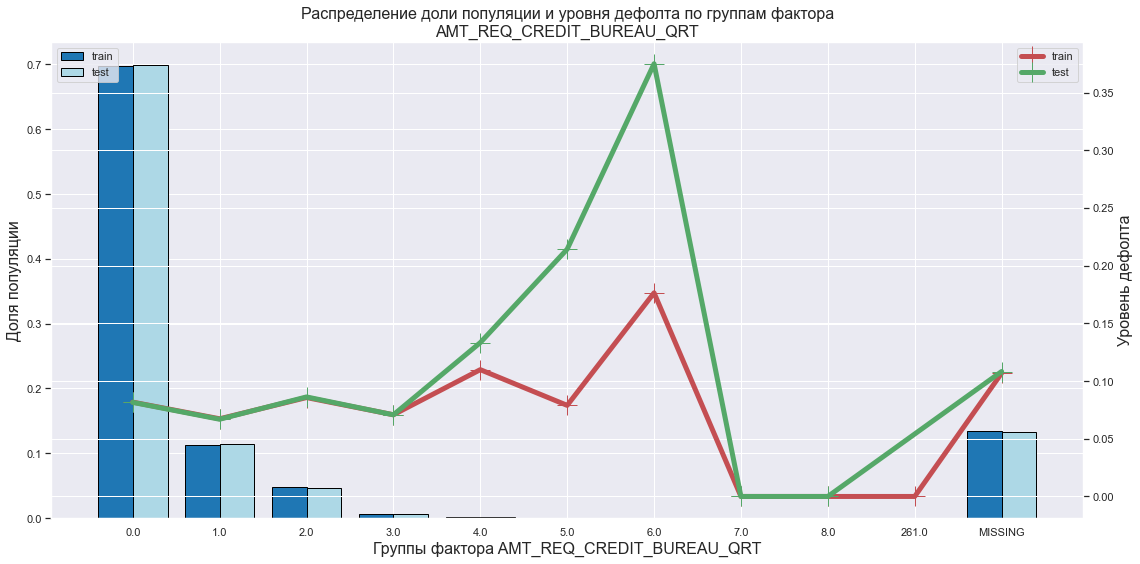

    test_flg GRP_AMT_REQ_CREDIT_BUREAU_QRT     cnt  def_cnt  def_rate  \
0          0                           0.0  122287     9996     0.082   
2          0                           1.0   19743     1329     0.067   
4          0                           2.0    8389      719     0.086   
7          0                           3.0    1045       74     0.071   
9          0                           4.0     273       30     0.110   
11         0                           5.0      38        3     0.079   
13         0                           6.0      17        3     0.176   
16         0                           7.0       4        0     0.000   
18         0                           8.0       5        0     0.000   
6          0                         261.0       1        0     0.000   
19         0                       MISSING   23614     2523     0.107   
1          1                           0.0   52448     4277     0.082   
3          1                           1.0    8563 

In [264]:
interrval_features_short = [col for col in good_features_long if col in interval_attributes]
category_features_short = [col for col in good_features_long if col in cat_attributes]

print_binning(data=train.copy(), 
              interval_attributes=[f'GRP_{col}' for col in interrval_features_short], 
              category_attributes=[f'GRP_{col}' for col in category_features_short], 
              target='TARGET',
              test_flg_name = 'test_flg'
              )

# Target prediction

In [265]:
from sklearn.linear_model import LogisticRegression
X_train = train[train['test_flg']==0][['WOE_'+col for col in good_features_long]]
y_train = train[train['test_flg']==0]['TARGET']
X_test = train[train['test_flg']==1][['WOE_'+col for col in good_features_long]]
y_test = train[train['test_flg']==1]['TARGET']

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

pred_train = logreg.predict_proba(X_train)[:, 1]
pred_test = logreg.predict_proba(X_test)[:, 1]

print(f'GINI train: {round(2*roc_auc_score(y_train, pred_train)-1, 4)}')
print(f'GINI test: {round(2*roc_auc_score(y_test, pred_test)-1, 4)}')

GINI train: 0.487
GINI test: 0.498


In [266]:
from catboost import CatBoostClassifier
import catboost as cb
X_train = train[train['test_flg']==0][['WOE_'+col for col in good_features_long]]
y_train = train[train['test_flg']==0]['TARGET']
X_test = train[train['test_flg']==1][['WOE_'+col for col in good_features_long]]
y_test = train[train['test_flg']==1]['TARGET']


# logreg = LogisticRegression(random_state=42)
# logreg.fit(X_train, y_train)

train_pool = cb.Pool(data = X_train, label = y_train) 
eval_pool = cb.Pool(data = X_test, label = y_test)
# test_pool = cb.Pool(data = x_test_r)

model = CatBoostClassifier(iterations=1000,
                          learning_rate=0.1,
                          depth=2)

# model.fit(X_train, y_train, eval)

model.fit(train_pool, 
          eval_set=eval_pool, 
          early_stopping_rounds=50, 
          verbose=False)

pred_train = model.predict_proba(X_train)[:, 1]
pred_test = model.predict_proba(X_test)[:, 1]


# pred_train = logreg.predict_proba(X_train)[:, 1]
# pred_test = logreg.predict_proba(X_test)[:, 1]

print(f'GINI train: {round(2*roc_auc_score(y_train, pred_train)-1, 4)}')
print(f'GINI test: {round(2*roc_auc_score(y_test, pred_test)-1, 4)}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

GINI train: 0.514
GINI test: 0.5098


In [267]:
from catboost import CatBoostClassifier
import catboost as cb
# X_train = train[train['test_flg']==0][['WOE_'+col for col in good_features_long]]
# y_train = train[train['test_flg']==0]['TARGET']
# X_test = train[train['test_flg']==1][['WOE_'+col for col in good_features_long]]
# y_test = train[train['test_flg']==1]['TARGET']

X_train = train[train['test_flg']==0][[col for col in interval_attributes+cat_attributes]]
y_train = train[train['test_flg']==0]['TARGET']
X_test = train[train['test_flg']==1][[col for col in interval_attributes+cat_attributes]]
y_test = train[train['test_flg']==1]['TARGET']


# logreg = LogisticRegression(random_state=42)
# logreg.fit(X_train, y_train)

train_pool = cb.Pool(data = X_train, label = y_train) 
eval_pool = cb.Pool(data = X_test, label = y_test)
# test_pool = cb.Pool(data = x_test_r)

model = CatBoostClassifier(iterations=1000,
                          learning_rate=0.1,
                          depth=2)

# model.fit(X_train, y_train, eval)

model.fit(train_pool, 
          eval_set=eval_pool, 
          early_stopping_rounds=50, 
          verbose=False)

pred_train = model.predict_proba(X_train)[:, 1]
pred_test = model.predict_proba(X_test)[:, 1]


# pred_train = logreg.predict_proba(X_train)[:, 1]
# pred_test = logreg.predict_proba(X_test)[:, 1]

print(f'GINI train: {round(2*roc_auc_score(y_train, pred_train)-1, 4)}')
print(f'GINI test: {round(2*roc_auc_score(y_test, pred_test)-1, 4)}')

GINI train: 0.5363
GINI test: 0.5208


In [268]:
from catboost import CatBoostClassifier
import catboost as cb
# X_train = train[train['test_flg']==0][['WOE_'+col for col in good_features_long]]
# y_train = train[train['test_flg']==0]['TARGET']
# X_test = train[train['test_flg']==1][['WOE_'+col for col in good_features_long]]
# y_test = train[train['test_flg']==1]['TARGET']

X_train = train[train['test_flg']==0][[col for col in interval_attributes+cat_attributes] + ['WOE_'+col for col in good_features_long]]
y_train = train[train['test_flg']==0]['TARGET']
X_test = train[train['test_flg']==1][[col for col in interval_attributes+cat_attributes] + ['WOE_'+col for col in good_features_long]]
y_test = train[train['test_flg']==1]['TARGET']


# logreg = LogisticRegression(random_state=42)
# logreg.fit(X_train, y_train)

train_pool = cb.Pool(data = X_train, label = y_train) 
eval_pool = cb.Pool(data = X_test, label = y_test)
# test_pool = cb.Pool(data = x_test_r)

model_target = CatBoostClassifier(iterations=3000,
                          learning_rate=0.1,
                          depth=6)

# model.fit(X_train, y_train, eval)

model_target.fit(train_pool, 
          eval_set=eval_pool, 
          early_stopping_rounds=50, 
          verbose=False)

pred_train_target = model_target.predict_proba(X_train)[:, 1]
pred_test_target = model_target.predict_proba(X_test)[:, 1]


# pred_train = logreg.predict_proba(X_train)[:, 1]
# pred_test = logreg.predict_proba(X_test)[:, 1]

print(f'GINI train: {round(2*roc_auc_score(y_train, pred_train_target)-1, 4)}')
print(f'GINI test: {round(2*roc_auc_score(y_test, pred_test_target)-1, 4)}')

GINI train: 0.5638
GINI test: 0.5218


In [269]:
# import optuna
# def objective(trial):
#     param = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#         "used_ram_limit": "3gb",
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = cb.CatBoostClassifier(**param)

#     gbm.fit(train_pool, eval_set=eval_pool, verbose=0, early_stopping_rounds=100)

#     t = gbm.predict_proba(X_test)[:, 1]
#     return 2*roc_auc_score(y_test, t)-1

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50, timeout=600)

In [270]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

default_prob = 0.25

y_pred = list(map(lambda x: 1 if x> default_prob else 0, pred_test_target))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.8992518902772406
0.25690960952099934
0.33573264781491
0.20806117572088578


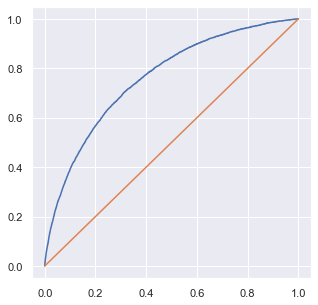

In [271]:
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(5, 5))
fpr, tpr, thresholds = roc_curve(y_test, pred_test_target)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])

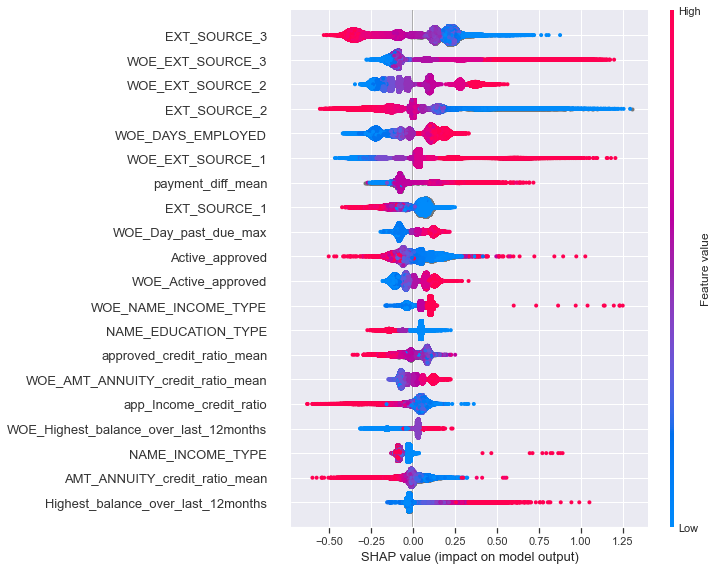

In [272]:
import shap
explainer = shap.TreeExplainer(model_target)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)


# Amount prediction

In [273]:
money_amount = 17447122764
percent_bank = 1.10
money_amount/len(test)

627053.0033064979

In [274]:
from catboost import CatBoostRegressor
import catboost as cb

X_train = train[train['test_flg']==0][[col for col in interval_attributes+cat_attributes] + ['WOE_'+col for col in good_features_long]]
y_train_amount = train[train['test_flg']==0]['AMT_CREDIT']
X_test = train[train['test_flg']==1][[col for col in interval_attributes+cat_attributes] + ['WOE_'+col for col in good_features_long]]
y_test_amount = train[train['test_flg']==1]['AMT_CREDIT']

train_pool = cb.Pool(data = X_train, label = y_train_amount) 
eval_pool = cb.Pool(data = X_test, label = y_test_amount)

model_amount = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=5)

model_amount.fit(train_pool, 
          eval_set=eval_pool, 
          early_stopping_rounds=50, 
          verbose=False)


pred_train_amount = model_amount.predict(X_train)
pred_test_amount = model_amount.predict(X_test)
pred_test_amount[pred_test_amount<0] = 0

In [275]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f'MAE {mean_absolute_error(y_test_amount, pred_test_amount)}')
print(f'MSE {mean_squared_error(y_test_amount, pred_test_amount, squared=False)}')

MAE 159820.38137221336
MSE 223382.7507194598


In [276]:
train['AMT_pred'] = np.nan
train['TARGET_pred'] = np.nan
train['PD_pred'] = np.nan

# train.loc[train['test_flg']==0, 'AMT_pred'] = pred_train
train.loc[train['test_flg']==1, 'AMT_pred'] = pred_test_amount
train.loc[train['test_flg']==1, 'TARGET_pred'] = y_pred
train.loc[train['test_flg']==1, 'PD_pred'] = pred_test_target


In [277]:
train.loc[train['test_flg']==1, 'AMT_pred'] = train.loc[train['test_flg']==1, 'AMT_pred'] * (1-train.loc[train['test_flg']==1, 'TARGET_pred'] )

In [278]:
valid = train[train['test_flg']==1].copy()

In [279]:
valid['AMT_pred'].sum()/valid['AMT_CREDIT'].sum()

0.9594265817613374

In [280]:
bad_pd_coef = 0.7225
good_pd_coef = 1.03
valid.loc[valid['PD_pred'] >=default_prob-0.1, 'AMT_pred'] *=bad_pd_coef
valid.loc[valid['PD_pred'] <=0.15, 'AMT_pred'] *=good_pd_coef


In [281]:
available_money = valid['AMT_CREDIT'].sum()-valid['AMT_pred'].sum()
available_money

1740759370.6914444

In [282]:
valid['Rating'] = (default_prob - valid['PD_pred']) 
valid['Rating'] = valid['Rating'].apply(lambda x: 0 if x<=0 else x)

In [283]:
rating_sum = valid['Rating'].sum()
rating_sum

12815.543716909893

In [284]:
valid['Rating'] = valid['Rating']* available_money/rating_sum

In [285]:
valid['AMT_pred'] = valid['AMT_pred'] + valid['Rating']

In [286]:
(valid['AMT_pred'] * (1-valid['TARGET'])).sum()* percent_bank

48639519063.236176

In [287]:
(valid['AMT_CREDIT'] * (1-valid['TARGET'])).sum()* percent_bank

47827777842.9

In [288]:
(valid['AMT_pred'] * (1-valid['TARGET'])).sum()* percent_bank/((valid['AMT_CREDIT'] * (1-valid['TARGET'])).sum()* percent_bank)

1.0169721709213106

In [289]:
valid['AMT_pred'].sum(), valid['AMT_pred'].sum()

(47096175780.0, 47096175780.0)

In [290]:
(valid['AMT_pred']<0).sum()

0

## УРА 1,6 процента в плюсе

# TEST

In [291]:
# X_test_1 = test[['WOE_'+col for col in good_features_long]]
X_test_1 = test[[col for col in interval_attributes+cat_attributes] + ['WOE_'+col for col in good_features_long]]
target_test = model_target.predict_proba(X_test_1)[:, 1]
amount_test = model_amount.predict(X_test_1)
amount_test[amount_test<0] = 0


In [292]:
test['PD'] = target_test
test['TARGET'] = test['PD'].apply(lambda x: 1 if x>default_prob else 0)
test['AMT_CREDIT'] = amount_test
test['AMT_CREDIT'] *= (1-test['TARGET'] )

In [293]:
test['TARGET'].sum()

1392

In [294]:
test.loc[test['PD'] >=default_prob-0.1, 'AMT_CREDIT'] *= bad_pd_coef
test.loc[test['PD'] <=0.15, 'AMT_CREDIT'] *= good_pd_coef

In [295]:
test['Rating'] = (default_prob - test['PD']) 
test['Rating'] = test['Rating'].apply(lambda x: 0 if x<=0 else x)
rating_sum_test = test['Rating'].sum()
rating_sum_test

4772.159311291042

In [296]:
avail_money_test = money_amount-test['AMT_CREDIT'].sum()
avail_money_test/10**9

0.6206346876844082

In [297]:
test['Rating'] = test['Rating']* avail_money_test/rating_sum_test
test['AMT_CREDIT'] = test['AMT_CREDIT'] + test['Rating']

In [298]:
test['AMT_CREDIT'].sum()-money_amount

0.0

In [299]:
(test['AMT_CREDIT'] < 0).sum()

0

In [300]:
test[targets].to_csv('test_try_1.csv')

In [301]:
test[test['TARGET'] == 1]

,app_Income_credit_ratio,app_Annuity_income_ratio,AMT_CREDIT_mean,approved_credit_ratio_mean,AMT_ANNUITY_credit_ratio_mean,approved_ratio,Highest_balance_over_last_12months,payment_diff_mean,Day_past_due_max,APARTMENTS_AVG,...,WOE_FLAG_OWN_CAR,WOE_NAME_EDUCATION_TYPE,WOE_DEF_30_CNT_SOCIAL_CIRCLE,WOE_AMT_REQ_CREDIT_BUREAU_QRT,WOE_REGION_RATING_CLIENT,WOE_CNT_CHILDREN,PD,TARGET,AMT_CREDIT,Rating
11,0.421941,0.136000,37098.000,0.822538,0.166807,1.000000,NaN,-69.862500,10.0,NaN,...,0.049196,0.099059,-0.039821,0.270103,0.359141,-0.054221,0.511916,1,0.0,0.0
17,0.430707,0.143000,159866.700,0.856540,0.107106,0.666667,0.000,712.487328,29.0,NaN,...,0.049196,0.099059,-0.039821,-0.025408,-0.032554,0.119588,0.278874,1,0.0,0.0
25,0.202208,0.253950,59364.000,0.781240,0.094857,0.500000,0.000,0.000000,22.0,NaN,...,0.049196,0.099059,0.236060,-0.025408,0.359141,-0.054221,0.696589,1,0.0,0.0
27,0.123896,0.389565,109278.000,0.955510,0.138700,1.000000,NaN,0.000000,-2.0,NaN,...,-0.102444,0.099059,-0.039821,-0.025408,0.359141,0.119588,0.322269,1,0.0,0.0
62,0.333890,0.241550,91449.000,1.111111,0.111120,1.000000,NaN,2177.530714,17.0,NaN,...,0.049196,0.099059,-0.039821,0.270103,-0.032554,-0.054221,0.496351,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27757,0.192237,0.333143,640359.000,0.896963,0.067855,1.000000,NaN,0.000000,-8.0,NaN,...,0.049196,0.099059,0.236060,-0.025408,-0.032554,-0.054221,0.384137,1,0.0,0.0
27766,0.157985,0.309300,28024.500,0.909918,0.078530,0.333333,NaN,660.231000,3.0,NaN,...,0.049196,0.099059,-0.039821,-0.025408,0.359141,-0.054221,0.573239,1,0.0,0.0
27785,0.703565,0.170600,95464.875,0.947992,0.136110,0.666667,NaN,9150.750000,7.0,NaN,...,0.049196,0.099059,0.236060,-0.025408,-0.032554,-0.054221,0.373653,1,0.0,0.0
27800,0.407019,0.164822,38710.500,1.126877,0.112480,0.500000,143906.625,0.000000,11.0,NaN,...,0.049196,0.099059,-0.039821,-0.025408,0.359141,-0.054221,0.253487,1,0.0,0.0


In [302]:
(valid['PD_pred'] * valid['AMT_pred']).sum()/(valid['TARGET'] * valid['AMT_CREDIT']).sum()

0.8034187538426983

In [303]:
test

,app_Income_credit_ratio,app_Annuity_income_ratio,AMT_CREDIT_mean,approved_credit_ratio_mean,AMT_ANNUITY_credit_ratio_mean,approved_ratio,Highest_balance_over_last_12months,payment_diff_mean,Day_past_due_max,APARTMENTS_AVG,...,WOE_FLAG_OWN_CAR,WOE_NAME_EDUCATION_TYPE,WOE_DEF_30_CNT_SOCIAL_CIRCLE,WOE_AMT_REQ_CREDIT_BUREAU_QRT,WOE_REGION_RATING_CLIENT,WOE_CNT_CHILDREN,PD,TARGET,AMT_CREDIT,Rating
0,0.277984,0.289400,50724.900,0.977703,0.127565,0.60,NaN,709.285263,9.0,0.0825,...,0.049196,0.099059,0.236060,0.026290,-0.032554,0.119588,0.141270,0,4.206394e+05,14140.655327
1,0.259799,0.309567,341070.750,0.936158,0.075470,0.75,NaN,-7987.057500,3.0,0.0495,...,0.049196,0.099059,-0.039821,-0.025408,-0.032554,-0.054221,0.080647,0,5.879892e+05,22024.936377
2,0.205696,0.238692,65677.500,1.006059,0.185495,1.00,NaN,430.978125,15.0,NaN,...,0.049196,0.099059,-0.039821,-0.025408,-0.032554,0.119588,0.091335,0,6.737782e+05,20634.889820
3,0.318357,0.147625,91961.100,0.946886,0.072399,1.00,0.00,1924.200000,5.0,0.1485,...,0.049196,0.099059,-0.039821,-0.025408,0.359141,0.119588,0.099409,0,4.652253e+05,19584.856463
4,0.591956,0.053026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.102444,0.099059,-0.039821,-0.025408,-0.032554,0.119588,0.064316,0,5.060787e+05,24148.821145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27819,0.297938,0.148657,176440.500,0.788773,0.061920,1.00,0.00,0.000000,12.0,0.0113,...,-0.102444,0.099059,-0.039821,-0.025408,0.359141,-0.054221,0.108066,0,5.132200e+05,18459.013676
27820,0.100000,0.275967,100197.000,1.179913,0.164400,1.00,NaN,-11250.000000,0.0,0.2784,...,-0.102444,0.099059,-0.039821,-0.025408,-0.032554,-0.054221,0.011731,0,1.659618e+06,30987.653624
27821,0.090896,0.304800,70602.075,1.031019,0.138895,1.00,0.00,533.715000,9.0,NaN,...,0.049196,0.099059,-0.039821,0.270103,-0.032554,0.119588,0.107865,0,1.379856e+06,18485.133135
27822,0.175000,0.167914,29326.500,0.965935,0.265101,1.00,NaN,0.000000,-2.0,0.0928,...,0.049196,0.099059,-0.039821,-0.025408,-0.032554,-0.054221,0.037677,0,1.027929e+06,27613.288416


In [304]:
test['Limit_new'] = test['AMT_CREDIT']

In [305]:
test[['TARGET', 'PD', 'Limit_new']]

,TARGET,PD,Limit_new
0,0,0.141270,4.206394e+05
1,0,0.080647,5.879892e+05
2,0,0.091335,6.737782e+05
3,0,0.099409,4.652253e+05
4,0,0.064316,5.060787e+05
...,...,...,...
27819,0,0.108066,5.132200e+05
27820,0,0.011731,1.659618e+06
27821,0,0.107865,1.379856e+06
27822,0,0.037677,1.027929e+06


In [306]:
test[['TARGET', 'PD', 'Limit_new']].to_csv('test_try_2.csv')